<a href="https://colab.research.google.com/github/mahima-c/Stock-Market-Forecasting/blob/main/Stock_Prize_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Stock Market Prediction and Forecasting Using stacked LSTM**

In [22]:
# data Collection

import pandas_datareader as pdr
import os

In [23]:
TIINGO_API_KEY="85f767849d48ecab3d73e334589408a866c2a229"
df=df = pdr.get_data_tiingo('APPL', api_key=TIINGO_API_KEY)

RemoteDataError: ignored

In [ ]:
df.head()

close    high  ...  divCash  splitFactor
symbol date                                       ...                      
GOOG   2015-12-23 00:00:00+00:00  750.31  754.21  ...      0.0          1.0
       2015-12-24 00:00:00+00:00  748.40  751.35  ...      0.0          1.0
       2015-12-28 00:00:00+00:00  762.51  762.99  ...      0.0          1.0
       2015-12-29 00:00:00+00:00  776.60  779.98  ...      0.0          1.0
       2015-12-30 00:00:00+00:00  771.00  777.60  ...      0.0          1.0

[5 rows x 12 columns]

In [ ]:
df.to_csv('appl.csv')

In [24]:
import pandas as pd
df=pd.read_csv("appl.csv")
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2015-12-23 00:00:00+00:00,750.31,754.21,744.00,753.47,1566726,750.31,754.21,744.00,753.47,1566726,0.0,1.0
1,GOOG,2015-12-24 00:00:00+00:00,748.40,751.35,746.62,749.55,527223,748.40,751.35,746.62,749.55,527223,0.0,1.0
2,GOOG,2015-12-28 00:00:00+00:00,762.51,762.99,749.52,752.92,1515716,762.51,762.99,749.52,752.92,1515716,0.0,1.0
3,GOOG,2015-12-29 00:00:00+00:00,776.60,779.98,766.43,766.69,1765012,776.60,779.98,766.43,766.69,1765012,0.0,1.0
4,GOOG,2015-12-30 00:00:00+00:00,771.00,777.60,766.90,776.60,1293521,771.00,777.60,766.90,776.60,1293521,0.0,1.0


In [26]:
df1=df.reset_index()['close']

In [27]:
df1

0        750.31
1        748.40
2        762.51
3        776.60
4        771.00
         ...   
1252    1760.06
1253    1767.77
1254    1763.00
1255    1747.90
1256    1731.01
Name: close, Length: 1257, dtype: float64

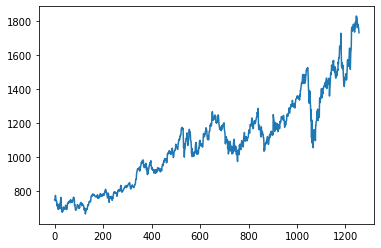

In [28]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [29]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler
import numpy as np


In [30]:

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [31]:
df1

array([[0.07074923],
       [0.06910229],
       [0.08126892],
       ...,
       [0.94396109],
       [0.93094082],
       [0.91637709]])

In [33]:
##splitting dataset into train and test split
# in time series
# we can use crossvalidation beacuse that choose randmly mean that loos the time stamp imformation so we can split by self
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [34]:
# convert an array of values into a dataset matrix
# timestep is that how much day previous depend on predict next day
# example seq is ---> 120,110,125,145,135
# timestep=3
# 120 110 125 o/p=145....
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [35]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [36]:
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(ytest.shape)


(716, 100)
(716,)
(339, 100)
(339,)


(None, None)

In [37]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [38]:

### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [39]:

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [40]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)


Epoch 1/100
12/12 [==============================] - 7s 270ms/step - loss: 0.0499 - val_loss: 0.0500
Epoch 2/100
12/12 [==============================] - 2s 178ms/step - loss: 0.0061 - val_loss: 0.0110
Epoch 3/100
12/12 [==============================] - 2s 180ms/step - loss: 0.0030 - val_loss: 0.0109
Epoch 4/100
12/12 [==============================] - 2s 174ms/step - loss: 0.0011 - val_loss: 0.0061
Epoch 5/100
12/12 [==============================] - 2s 182ms/step - loss: 0.0011 - val_loss: 0.0065
Epoch 6/100
12/12 [==============================] - 2s 185ms/step - loss: 9.7547e-04 - val_loss: 0.0069
Epoch 7/100
12/12 [==============================] - 2s 174ms/step - loss: 9.5677e-04 - val_loss: 0.0066
Epoch 8/100
12/12 [==============================] - 2s 175ms/step - loss: 9.5817e-04 - val_loss: 0.0070
Epoch 9/100
12/12 [==============================] - 2s 174ms/step - loss: 9.7136e-04 - val_loss: 0.0066
Epoch 10/100
12/12 [==============================] - 2s 175ms/step - loss:

In [44]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


In [45]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [46]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

981.971127616181

In [47]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

1395.2381684510165

No handles with labels found to put in legend.


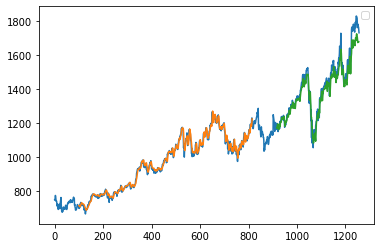

In [51]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()
plt.show()

In [52]:
len(test_data)

440

In [54]:
test_data.shape

(440, 1)

In [71]:
x_input=test_data[340:].reshape(1,-1)
x_input.shape

(1, 100)

In [72]:
temp_input=list(x_input)
temp_input

[array([0.74430255, 0.7024911 , 0.69515318, 0.68697887, 0.69442888,
        0.7172704 , 0.71243307, 0.71382132, 0.70021471, 0.7228924 ,
        0.73309305, 0.72384952, 0.73268778, 0.76771317, 0.75816785,
        0.78767472, 0.7865279 , 0.79323636, 0.810499  , 0.84857682,
        0.83301286, 0.84170453, 0.83288352, 0.85575953, 0.91402309,
        0.8394885 , 0.7956852 , 0.74511309, 0.76629905, 0.74479405,
        0.7350504 , 0.73380873, 0.75291663, 0.73520561, 0.71332983,
        0.68268476, 0.65782553, 0.68740138, 0.64407233, 0.65535081,
        0.66972485, 0.68659084, 0.69073836, 0.69097117, 0.70863908,
        0.681331  , 0.70512964, 0.6770369 , 0.68294344, 0.70505204,
        0.73030792, 0.77681012, 0.77899166, 0.77588749, 0.76817018,
        0.78013848, 0.74702733, 0.76541091, 0.79764255, 0.81662973,
        0.8387642 , 0.79517646, 0.80708441, 0.73151509, 0.77516318,
        0.82152742, 0.82585602, 0.8467057 , 0.93200141, 0.94428013,
        0.94288326, 0.94396109, 0.92446518, 0.93

In [73]:
temp_input=temp_input[0].tolist()

In [74]:
temp_input

[0.7443025531804818,
 0.7024910970656965,
 0.6951531822062033,
 0.6869788657704811,
 0.6944288756865823,
 0.7172703991446284,
 0.7124330663171602,
 0.7138213204797669,
 0.7002147051468876,
 0.7228923973683529,
 0.7330930475196814,
 0.7238495166978521,
 0.73268778077656,
 0.7677131746182301,
 0.7581678494132255,
 0.787674717391117,
 0.7865278987350505,
 0.7932363567382065,
 0.8104989954558389,
 0.8485768239159116,
 0.8330128564407232,
 0.8417045346761748,
 0.8328835159907911,
 0.855759530235486,
 0.9140230915816613,
 0.8394885016340009,
 0.795685202590258,
 0.7451130866667243,
 0.7662990523656369,
 0.7447940468902244,
 0.7350503996619903,
 0.7338087313426401,
 0.7529166271459736,
 0.7352056082019093,
 0.713329826770024,
 0.6826847628327283,
 0.657825528355738,
 0.6874013779069267,
 0.6440723271796022,
 0.6553508144136998,
 0.6697248497495106,
 0.6865908444206842,
 0.6907383615151802,
 0.6909711743250583,
 0.7086390797858121,
 0.6813309994567701,
 0.7051296422443155,
 0.6770368965190176,

In [77]:
len(temp_input)

101

In [76]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print("length is",len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)


0 day input [0.7350504  0.73380873 0.75291663 0.73520561 0.71332983 0.68268476
 0.65782553 0.68740138 0.64407233 0.65535081 0.66972485 0.68659084
 0.69073836 0.69097117 0.70863908 0.681331   0.70512964 0.6770369
 0.68294344 0.70505204 0.73030792 0.77681012 0.77899166 0.77588749
 0.76817018 0.78013848 0.74702733 0.76541091 0.79764255 0.81662973
 0.8387642  0.79517646 0.80708441 0.73151509 0.77516318 0.82152742
 0.82585602 0.8467057  0.93200141 0.94428013 0.94288326 0.94396109
 0.92446518 0.93508834 0.93261363 0.95605012 0.95980961 0.95012632
 0.92997508 0.94475438 0.92601726 0.91969683 0.94903124 0.95123003
 0.96999302 0.94201236 0.97422676 0.99996551 0.99894803 1.
 0.99266209 0.99186017 0.96218085 0.95459288 0.9601459  0.94142602
 0.94807412 0.94396109 0.93094082 0.91637709 0.85062611 0.80780947
 0.76364064 0.7294215  0.70748717 0.69657564 0.69351465 0.69444066
 0.69576448 0.69477755 0.68992072 0.68078786 0.6679399  0.65259254
 0.63625342 0.62037104 0.60606354 0.59396678 0.58421797 0.5

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)


In [69]:
import numpy as np

arr = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

newarr = arr.reshape(1, 12, 1)

print(newarr)

[[[ 1]
  [ 2]
  [ 3]
  [ 4]
  [ 5]
  [ 6]
  [ 7]
  [ 8]
  [ 9]
  [10]
  [11]
  [12]]]
